# Thermal Engineering Demo

## Introduction

### Why do I need "quick" access to mission length data (full resolution and statisticals)?


 - Analysis and Trending
   - Communicating health and safety conditions
   - Predicting Temperatures
   - Limit sensing (shown below)
   - Trending to spot potential performance or environmental issues
   - Correlating health and safety data to unexpected or anomalous performance
     - Heater Behavior vs Regional Temperatures
     - Power usage during events

   
 - Filtering of Data
   - Data when equipment in a particular state
   - Thermistor dropouts (onboard hardware issues)
   - Incorrectly read/stored data (double bit errors)
   - Incorrectly decommed data (software issues)
   - Invalid data (stale data)
 
 
 - Thermal Modeling
   - Short term planning to avoid thermal limits
   - Long term planning to schedule observations at favorable times of the year
 


### Benefits of Python/HDF5 Based Archive

 - Open Source
   - No purchase cost
   - Auditable


 - Interface with:
   - Web technologies (e.g. Django, Flask)
   - Industry standard numerical libraries (e.g. Numpy, Scipy)
   - Widely used plotting libraries (e.g. Matplotlib)


 - Portable Archive
   - HDF5 includes optional data compression
   - Relevant data can be stored on a laptop
   - Local storage avoids slow data transfer speeds (or lack of bandwidth capable of transfering gigabytes in short periods of time)
   
   
 - Python is an excellent language for engineers and scientists
   - Readable (reasonably clean syntax)
   - Versatile
   - Reliable
   - Easy to learn the basics
   - Portable applications
   - Marketable skill
   - Excellent support community
   - Comprehensive standard library
   - Widespread use and deployment
   - Namespace organization
   

## General Library Imports

In [1]:
import cPickle as pickle
import sys
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML
import jinja2 as ja
from matplotlib import rcParams, rc, font_manager
from matplotlib.ticker import AutoMinorLocator
import json
from os.path import expanduser
import urllib
sys.path.insert(0, './xija')
import xija

from Chandra.Time import DateTime
from Ska.engarchive import fetch_eng as fetch

home = expanduser("~")
sys.path.append(home + '/AXAFLIB/pylimmon/')
import pylimmon

%matplotlib inline

# You may see an error below tothe effect of "The `IPython.kernel` package has been
# deprecated..." and "The `IPython.parallel` package has been deprecated". These errors
# are ok and do not impact this notebook. My understanding is that these will be fixed in
# ipython before the next major release.

/home/ska/anaconda/envs/skatest_new/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/home/ska/anaconda/envs/skatest_new/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


----------------

## Limit Sensing in Python

### Additional Function Definitions

In [2]:
def check_violations(thermdict, t1, t2):
    """Check a list of MSIDs for limit/expected state violations.
    
    :param thermdict: Dictionary of MSID information (MSID name, condition type, etc.)
    :param t1: String containing start date in HOSC format
    :param t2: String containgin stop date in HOSC format
    
    """
    t1 = DateTime(t1).date
    t2 = DateTime(t2).date

    allviolations = {}
    missingmsids = []
    checkedmsids = []
    for key in thermdict.keys():
        greta_msid = thermdict[key]['greta_msid']
        try:
            if thermdict[key]['type'] == 'limit':
                if "wide" in greta_msid.lower():
                    violations = handle_widerange_cases(key, t1, t2, greta_msid)
                    checkedmsids.append(key)
                else:
                    violations = pylimmon.check_limit_msid(key, t1, t2, greta_msid=greta_msid)
                    checkedmsids.append(key)
            elif thermdict[key]['type'] == 'expst':
                violations = pylimmon.check_state_msid(key, t1, t2, greta_msid=greta_msid)
                checkedmsids.append(key)
                
            if violations['any']:
                allviolations[key] = violations
            
        except IndexError:
            print('{} not in DB'.format(key))
            missingmsids.append(key)

    return allviolations, missingmsids, checkedmsids

    
def handle_widerange_cases(key, t1, t2, greta_msid):
    """Handle special widerange MSIDs.
    
    :param key: Name of MSID as represented in Ska Engineering Archive
    :param t1: String containing start time in HOSC format
    :param t2: String containgin stop time in HOSC format
    :greta_msid: Name of MSID as represented in GRETA
    
    Note: Some MSID names differ between Ska and GRETA. Widerange MSIDs are one such case. For example
    OOBTHR35 is used for this measurement in both Ska and GRETA before this MSID was switched to 
    widerange read mode. Afterwards GRETA uses OOBTHR35_WIDE whereas Ska still uses OOBTHR35 for 
    continuity.
    """
    if DateTime(t2).secs <= DateTime('2014:342:16:30:00').secs:
        violations = pylimmon.check_limit_msid(key, t1, t2, greta_msid=key)
    elif DateTime(t1).secs >= DateTime('2014:342:16:33:00').secs:
        violations = pylimmon.check_limit_msid(key, t1, t2, greta_msid=greta_msid)
    else:
        t2_a = np.min((DateTime(t2).secs, DateTime('2014:342:16:30:00').secs))
        violations = pylimmon.check_limit_msid(key, t1, t2_a, greta_msid=key)
        t1_b = np.min((DateTime(t2).secs, DateTime('2014:342:16:33:00').secs))
        violations_b = pylimmon.check_limit_msid(key, t1_b, t2, greta_msid=greta_msid)

        for limittype in ['warning_low', 'caution_low', 'caution_high', 'warning_high']:
            if limittype in violations_b.keys():
                if limittype in violations.keys():
                    violations[limittype]['extrema'].extend(violations_b[limittype]['extrema'])
                    violations[limittype]['times '].extend(violations_b[limittype]['times '])
                    violations[limittype]['timespans '].extend(violations_b[limittype]['timespans '])
                else:
                    violations[limittype] = violations_b[limittype]
                    violations['any'] = True
                
    return violations

def add_violation_info(allviolations):
    """Add contextual information for any limit/expected state violations.
    
    :param allviolations: Dictionary of violation data
    
    """
    
    for key in allviolations.keys():
        try:
            t1 = DateTime().secs
            data = fetch.Msid(key, t1-3600*24*30, t1, stat='daily')
            desc = data.tdb.technical_name
        except:
            desc = 'No Description in TDB'
        allviolations[key]['description'] = desc

        if 'expst' in allviolations[key]['type']:
            allviolations[key]['total_duration'] = sum([b - a for a, b in allviolations[key]['timespans']]) / 3600.
            allviolations[key]['num_excursions'] = len(allviolations[key]['timespans'])
            allviolations[key]['expectation'] = '= {}'.format(allviolations[key]['limits'][0])
            allviolations[key]['observed'] = ', '.join(np.unique(allviolations[key]['extrema']))
            allviolations[key]['datespans'] = [(DateTime(a).date, DateTime(b).date) 
                for a, b in allviolations[key]['timespans']]
        else:
            for limtype in ['warning_low', 'caution_low', 'caution_high', 'warning_high']:
                if limtype in allviolations[key].keys():
                    allviolations[key][limtype]['total_duration'] = sum([b - a for a, b in 
                        allviolations[key][limtype]['timespans']]) / 3600.
                    if 'high' in limtype:
                        allviolations[key][limtype]['observed'] = np.max(allviolations[key][limtype]['extrema'])
                        allviolations[key][limtype]['expectation'] = '< {}'.format(
                            allviolations[key][limtype]['limits'][0])
                    elif 'low' in limtype:
                        allviolations[key][limtype]['observed'] = np.min(allviolations[key][limtype]['extrema'])
                        allviolations[key][limtype]['expectation'] = '> {}'.format(
                            allviolations[key][limtype]['limits'][0])

                    allviolations[key][limtype]['num_excursions'] = len(allviolations[key][limtype]['timespans'])

                    allviolations[key][limtype]['datespans'] = [(DateTime(a).date, DateTime(b).date) 
                        for a, b in allviolations[key][limtype]['timespans']]
    return allviolations



### Run Limit Sensing Code, Output Table

In [3]:
thermdict, missing, notinarchive = pickle.load(open(home + '/AXAFDATA/weekly_report_data/thermalmsiddata.pkl','r'))

t1 = DateTime('2015:006:00:00:00.000').date
t2 = DateTime('2015:008:00:00:00.000').date
dayrange = (t1[:9] + '-' + t2[:9]).replace(':', '')

allviolations, missingmsids, checkedmsids = check_violations(thermdict, t1, t2)
allviolations = add_violation_info(allviolations)

hours = (DateTime(t2).secs - DateTime(t1).secs)/3600.
print('\nChecked {} MSIDs at full resolution over {} hour period, {} MSIDs left unchecked (missing)\n'.format(
        len(checkedmsids), hours, len(missingmsids)) )

env = ja.Environment(loader=ja.FileSystemLoader('./templates'))
template = env.get_template('index.htm')
webpage = template.render(dayrange=dayrange, violations=allviolations)
HTML(webpage)

# You may see errors below to the effect of "RuntimeWarning: invalid value encountered...".
# These are ok and will hopefully be fixed in Numpy eventually.

eob2ts1s not in DB
eotb3t1c not in DB
eob1ts1s not in DB
eoeb2rl3 not in DB
4m28irbx not in DB
4m5irbx not in DB
eob1ts2s not in DB

Checked 983 MSIDs at full resolution over 48.0 hour period, 7 MSIDs left unchecked (missing)



/home/ska/AXAFLIB/pylimmon/pylimmon/pylimmon.py:448: RuntimeWarning: invalid value encountered in greater
  limcheck = data[msid].vals > intlim
/home/ska/AXAFLIB/pylimmon/pylimmon/pylimmon.py:450: RuntimeWarning: invalid value encountered in less
  limcheck = data[msid].vals < intlim


------

## General Telemetry Trending

### Query Data

In [4]:
fss = fetch.MSID('tfssbkt2','1999:220:00:00:00','2015:212:23:59:59',stat='5min')
bad1 = fss.vals > 140
bad2 = fss.times < DateTime('2000:100').secs
bad = bad1 & bad2
fss.times = fss.times[~bad]
fss.vals = fss.vals[~bad]

safetylimits = pylimmon.get_mission_safety_limits('tfssbkt2')

### Generate Plot

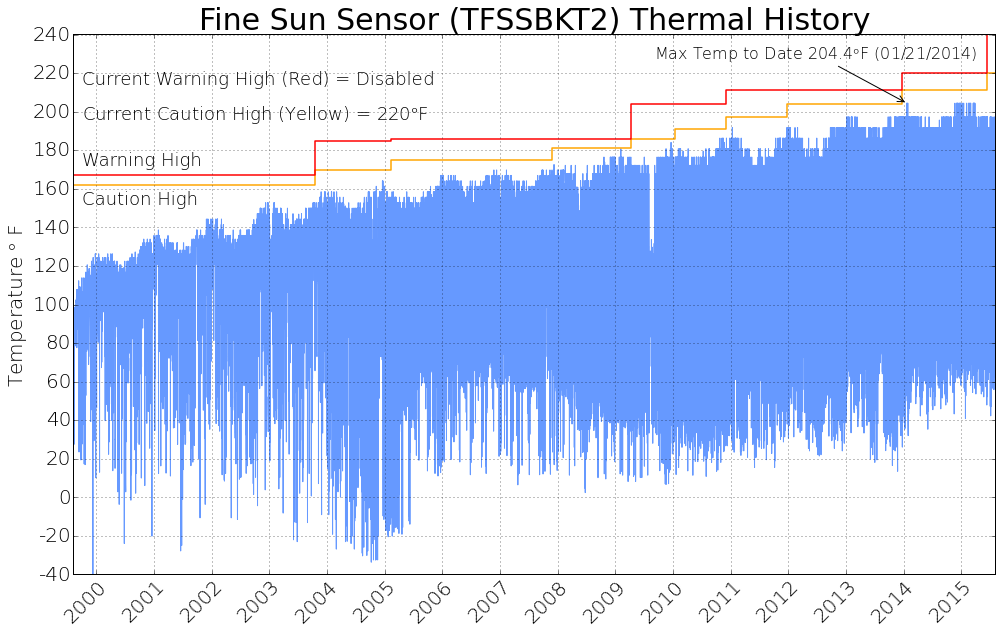

In [5]:
rcParams['xtick.major.pad'] = 4
rcParams['ytick.major.pad'] = 4
rcParams.update({'font.size': 18})
rc('font', family='sans-serif') 
rc('font', weight='light')
lightfont = font_manager.FontProperties(weight='light')

xdate = ['%d:001:00:00:00'%n for n in range(1999,2017,1)]
xtik = DateTime(xdate).secs
xlab = np.array([t[:4] for t in xdate])

fig = plt.figure(figsize=(16,10),facecolor=[1,1,1])
ax = fig.add_axes((0.1, 0.15, 0.8, 0.75))

dataline = ax.plot(fss.times,fss.vals,color=[.4,.6,1])

ax.grid(visible=True)
ax.set_ylabel('Temperature $\degree$ F',fontsize=20, fontproperties=lightfont)
ax.set_xticklabels('')
ax.set_xticks(xtik)
ax.set_xticklabels(xlab, fontsize=20, ha='right', rotation=45, rotation_mode='anchor')
ax.set_xlim(fss.times[0],fss.times[-1])
ax.set_ylim(-40,240.05)
ax.set_yticks(range(-40,250,20))
ax.set_yticklabels(ax.get_yticks(), fontsize=20)

_ = ax.step(safetylimits['times'], safetylimits['caution_high'], where='post', color='orange', linewidth=1.5)
_ = ax.step(safetylimits['times'], safetylimits['warning_high'], where='post', color='red', linewidth=1.5)

whtext = ax.text(fss.times[0]+5e6, 212,
                 'Current Warning High (Red) = Disabled', ha="left",
                 va="bottom", size=18)
chtext = ax.text(fss.times[0]+5e6, 193,
                 'Current Caution High (Yellow) = 220$\degree$F', ha="left",
                 va="bottom", size=18)

anom2 = ax.annotate('Max Temp to Date 204.4$\degree$F (01/21/2014)',
                    xy=(DateTime('2014:021').secs, 204.4),  xycoords='data',
                    xytext=(DateTime('2015:100').secs,230),
                    textcoords='data',arrowprops=dict(arrowstyle="->"),
                    horizontalalignment='right', verticalalignment='center',
                    fontsize=16)

whtextsmall = ax.text(fss.times[0]+5e6, 170,'Warning High', ha="left", va="bottom", size=18)
chtextsmall = ax.text(fss.times[0]+5e6, 159,'Caution High', ha="left", va="top", size=18)
ax.set_title('Fine Sun Sensor (TFSSBKT2) Thermal History', fontsize=30)


----------

## MUPS Thruster Firings and Valve Temperatures

### Query and plot data

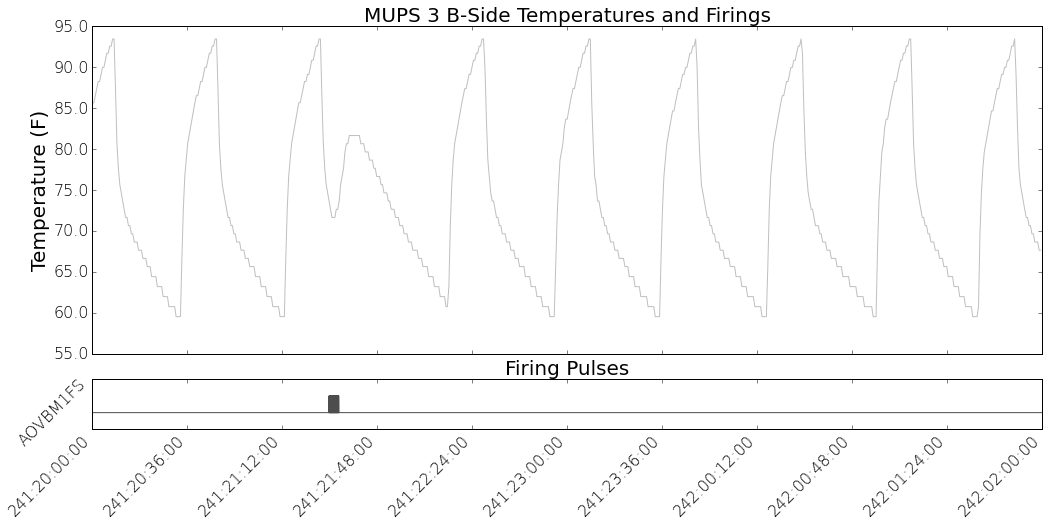

In [6]:

msids = ['AOVBM1FS', 'PM3THV2T']

t1 = '2013:241:20:00:00'
t2 = '2013:242:02:00:00'
data = fetch.Msidset(msids, t1, t2)

xticks = np.linspace(DateTime(t1).secs, DateTime(t2).secs, 11)
xticklabels = [DateTime(t).date[5:17] for t in xticks]

fig = plt.figure(figsize=[15,7], facecolor='w')
rect = [0.06, 0.15, 0.88, 0.1]
ax1 = fig.add_axes(rect)

ax1.plot(data[msids[0]].times, data[msids[0]].raw_vals, color=[0.3, 0.3, 0.3])
ax1.set_ylim(-1, 2)
ax1.set_yticks([0,2])
ax1.set_yticklabels([msids[0],], rotation=45, fontsize=16)
for t in ax1.yaxis.get_ticklines():
    t.set_visible(False) 
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=16)
ax1.set_xlim(xticks[0], xticks[-1])
plt.title('Firing Pulses', fontsize=20)

rect = [0.06, 0.3, 0.88, 0.65]
ax2 = fig.add_axes(rect)
ax2.plot(data['PM3THV2T'].times, data['PM3THV2T'].vals, color=[0.5, 0.5, 0.5], alpha=0.5)
ax2.set_ylabel('Temperature (F)', fontsize=20)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=16)
ax2.set_xticks(xticks)
ax2.set_xticklabels('')
ax2.set_xlim(xticks[0], xticks[-1])

plt.title('MUPS 3 B-Side Temperatures and Firings', fontsize=20)

--------

## Generate Pitch History Step Plot

### Define helper functions

In [7]:
def calcquantiles(errors):
    """ Calculate the error quantiles.

    :param error: model errors (telemetry - model)
    :returns: datastructure that includes errors (input) and quantile values

    """

    quants = np.arange(0, 1, .01)
    quants[0] = 1e-6
    esort = np.sort(errors)
    
    stats = {}
    for quant in quants:
        d = esort[quant * len(esort) - 1]
        stats.update({unicode(quant): d})
    stats['median'] = np.median(esort)
    stats['error'] = errors
    stats['maximum'] = np.max(errors)
    stats['minimum'] = np.min(errors)

    return stats

def getreportboundaries():
    currentyear = int(DateTime().date[:4])
    pairs = [[str(y) + 'Aug01 at 00:00:00.000', str(y+1) + 'Feb01 at 00:00:00.000'] 
             for y in range(1999, currentyear + 1, 1)] 
    reportboundaries = [pairs[i][j] for i in range(len(pairs)) for j in range(2)]
    if DateTime(reportboundaries[-1]).secs > DateTime().secs:
        reportboundaries.pop(-1)
    return reportboundaries


### Query and process data

In [8]:
data = fetch.Msid('pitch', '1999:224:00:00:00', stat='5min')
data.vals = np.array(data.vals, dtype=type(np.float))
good = data.vals > 45
data.vals = data.vals[good]
data.times = data.times[good]
reportboundaries = getreportboundaries()

stats = {}
meanvals = []
for t1, t2 in zip(reportboundaries[:-1], reportboundaries[1:]):
    ind1 = data.times >= DateTime(t1).secs
    ind2 = data.times < DateTime(t2).secs
    ind = ind1 & ind2
    meanval = np.mean(data.vals[ind])
    quant = calcquantiles(data.vals[ind] - meanval)
    quantkeys = quant.keys()
    _ = quantkeys.remove('error')
    meanvals.append(meanval)
    for key in quantkeys:
        if key not in stats.keys():
            stats.update({key:[]})
        stats[key].append(quant[key])
        
meanvals.append(meanval)
for key in quantkeys:
    if key not in stats.keys():
        stats.update({key:[]})
    stats[key].append(quant[key])

meanvals = np.array(meanvals)

/home/ska/anaconda/envs/skatest_new/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Generate Plot

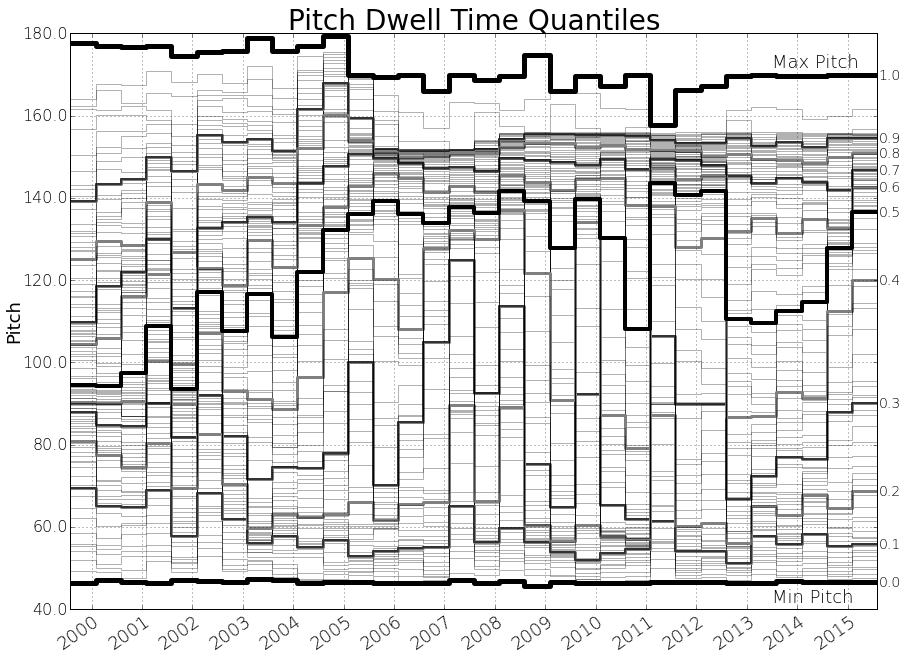

In [9]:

rcParams['xtick.major.pad'] = 4
rcParams['ytick.major.pad'] = 4
rcParams.update({'font.size': 18})
rc('font', family='sans-serif') 
rc('font', weight='light')
lightfont = font_manager.FontProperties(weight='light')

minorLocator   = AutoMinorLocator(1)
xdate = ['%d:001:00:00:00'%n for n in range(2000,2017,1)]
xtik = DateTime(xdate).secs
xlab = np.array([t[:4] for t in xdate])

    
colors = {'t33':'#4a0429', 'g3':'#5b2a05', 'g6':'#033834', 't52':'#385405'}
datefontsize=18

fig = plt.figure(figsize=(14,10),facecolor=[1,1,1])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.hold(True)

statskeys = stats.keys()
statmin =  meanvals + np.array(stats['minimum'])
statmax =  meanvals + np.array(stats['maximum'])
statmedian =  meanvals + np.array(stats['median'])

maxdate = DateTime(reportboundaries).secs[-1]
decilekeys = [unicode(d) for d in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]]

for key in statskeys:
    stat =  meanvals + np.array(stats[key])
    ax.step(DateTime(reportboundaries).secs, stat, color='black', alpha=0.3, label=key, 
            linewidth=1, where='post')
    if key in decilekeys:
        ax.step(DateTime(reportboundaries).secs, stat, color=[0.5,0.5,0.5], alpha=1, linewidth=3,
                label=key, where='post')
        ax.text(maxdate + 20*24*3600, stat[-1], unicode(key), va='center', ha='left', fontsize=14)
    if key in [u'0.1', u'0.3', u'0.7', u'0.9']:
        ax.step(DateTime(reportboundaries).secs, stat, color=[0.2,0.2,0.2], alpha=1, linewidth=2,
                label=key, where='post')

ax.step(DateTime(reportboundaries).secs, statmax, color='black', label=key, linewidth=5, where='post')
ax.text(maxdate + 20*24*3600, statmax[-1], unicode('1.0'), va='center', ha='left', fontsize=14)
ax.step(DateTime(reportboundaries).secs, statmedian, color='black', label=key, linewidth=4, where='post')
ax.step(DateTime(reportboundaries).secs, statmin, color='black', label=key, linewidth=5, where='post')
ax.text(maxdate + 20*24*3600, statmin[-1], unicode('0.0'), va='center', ha='left', fontsize=14)

ax.text(DateTime('2013:180').secs, 173, 'Max Pitch', va='center', ha='left', fontsize=18)
ax.text(DateTime('2013:180').secs, 43, 'Min Pitch', va='center', ha='left', fontsize=18)

ax.set_title('Pitch Dwell Time Quantiles', fontsize=28)
ax.set_ylabel('Pitch', labelpad=-1, fontsize=datefontsize)
ax.set_xticks(xtik)
_ = ax.set_xticklabels(xlab, rotation=35, ha='right', fontsize=datefontsize, rotation_mode='anchor')
ax.set_xlim(DateTime(reportboundaries[0]).secs, DateTime(reportboundaries[-1]).secs)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(which='both', axis='both')

_ = ax.set_yticklabels(ax.get_yticks(), fontsize=16) # putting this at the end seems to avoid a bug



------

## Plot MUPS Valve Temperature Model

In [10]:
def CtoF(temp):
    return np.array(temp) * 1.8 + 32.0

def FtoC(temp):
    return (np.array(temp) - 32.0) / 1.8

def mups2a_model(tstart='2014:001:00:00:00.000', tstop='2015:001:00:00:00.000'):
    model_spec_url = 'https://raw.githubusercontent.com/sot/chandra_models/0ded1ae625a2735b00c94df36f12a95c3fe824ec/chandra_models/xija/mups_valve/pm2thv1t_spec.json'
    response = urllib.urlopen(model_spec_url);
    model_spec = json.loads(response.read())
    model = xija.ThermalModel('mups2a', start=tstart, stop=tstop, model_spec=model_spec)
    model.comp['mups0'].set_data(70)
    model.make()
    model.calc()
    mups = model.get_comp('pm2thv1t')
    mups_times = mups.times
    mups_model_temp = mups.mvals
    mups_telem_temp = mups.dvals
    return (mups_times, mups_model_temp, mups_telem_temp)

def genplot(tstart='2014:200', tstop='2014:250', ymin=0, ymax=200):
    lightfont = font_manager.FontProperties(weight='light')
    xtick = np.linspace(DateTime(tstart).secs, DateTime(tstop).secs, 10)
    xlab = [lab[:11] for lab in DateTime(xtick).date]
    fig = plt.figure(facecolor=[1,1,1],figsize=(15,8))
    ax = fig.add_axes([0.1, 0.15, 0.8, 0.7])
    ax.set_xticks(xtick)
    ax.set_xticklabels(xlab, fontsize=20, rotation=45, ha='right', rotation_mode="anchor")
    ax.grid(True)
    ax.set_ylabel('Temperature in F', fontsize=22, fontproperties=lightfont)
    ax.set_xlabel('Time (Seconds)', fontsize=22, fontproperties=lightfont)
    ax.set_ylim(ymin, ymax)
    ax.set_yticklabels(ax.get_yticks(), fontsize=20)
    ax.set_xlim(DateTime(tstart).secs, DateTime(tstop).secs)
    return fig, ax


Fetching msid: pm2thv1t over 2015:014:23:32:48.816 to 2015:045:00:19:36.816
Fetching msid: aosares1 over 2015:014:23:32:48.816 to 2015:045:00:19:36.816
Fetching msid: aoeclips over 2015:014:23:32:48.816 to 2015:045:00:19:36.816


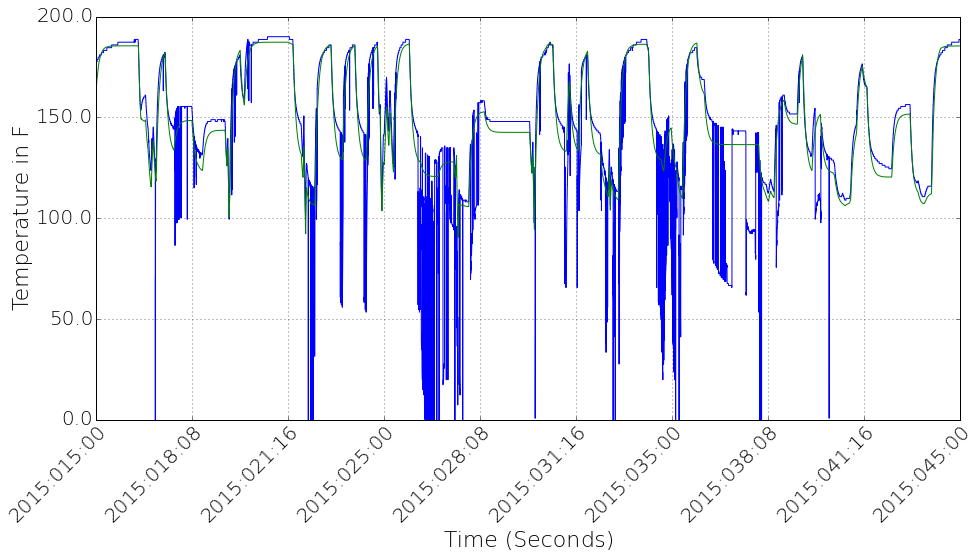

In [11]:
t1='2015:015:00:00:00.000'
t2='2015:045:00:00:00.000'

data = fetch.Msid('pm2thv1t', t1, t2, stat=None)
data.vals = data.vals.astype('float')

mups_times, mups_model_temp, mups_telem_temp = mups2a_model(tstart=t1, tstop=t2)
modeltemps = np.interp(data.times, mups_times, mups_model_temp)

fig, ax = genplot(tstart=t1, tstop=t2)
ax.plot(data.times, data.vals)
ax.plot(mups_times, CtoF(mups_model_temp))